<a href="https://colab.research.google.com/github/yaqianhuang/AI2025/blob/main/instance_retrieval_for_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training-data-based explainability

In this tutorial we will investigate which training data items are similar to generated outputs, and hence could have influenced it.

In step one, we generate an output with Olmo1B, a small open source language model.

In step two, we search an index to find similar examples from the data Olmo1B was fine-tuned on (i.e. we retrieve training examples using a fast search engine).

## Step 1: Generate responses with a language model

Before we run a deep learning model in Colab, we need to give the notebook access to a TPU (tensor processing unit), a GPU-type processor that is necessary for parallelizing tensor computations.

***For this, click 'Change runtime type' in the upper right corner of the notebook (see image) and then select T4.*** Afterwards, run the next cell to import torch and transformers, two deep learning libraries necessary to run a language model.

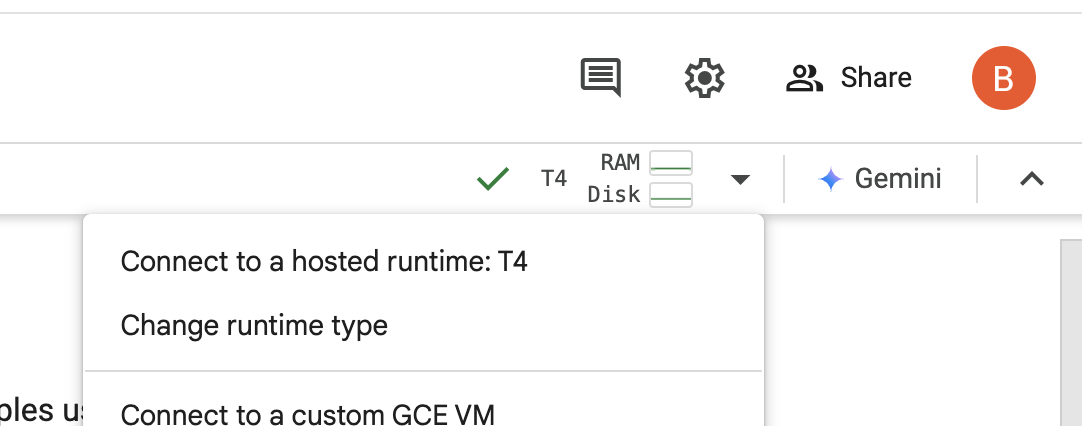

In [ ]:
pip install hf-transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.6 MB/s eta 0:00:00


In [ ]:
# this bypasses the huggingface 50MB/s throttle when downloading models
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
torch.cuda.is_available()
device = torch.device("cuda")

Next, let's download the language model to your colab. This can take some while.

In [ ]:
model = AutoModelForCausalLM.from_pretrained("amd/AMD-OLMo-1B-SFT").to(device)
tokenizer = AutoTokenizer.from_pretrained("amd/AMD-OLMo-1B-SFT")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

Next, we define a function for generating responses to user requests.

In [ ]:
def llm_response(query):
  bos = tokenizer.eos_token
  template = bos + "<|user|>\n{role_user}\n<|assistant|>\n"
  input_text = template.format(role_user=query)
  inputs = tokenizer([input_text], return_tensors='pt', return_token_type_ids=False, max_length=2048, truncation=True).to(device)
  outputs = model.generate(**inputs, max_new_tokens=1000, do_sample=True, top_k=1, top_p=0.95)
  answer_with_markup = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
  return answer_with_markup.split("<|assistant|>\n")[-1]

user_query = "What is the chemical formula for water?"

print(llm_response(user_query))

Water is a chemical compound with the formula H2O. It is a colorless, odorless, and tasteless liquid that is essential for life. Water is made up of two hydrogen atoms and one oxygen atom. The chemical formula for water is derived from the elements that make up water. Hydrogen has one proton in its nucleus, and oxygen has eight protons in its nucleus. The number of protons in an atom determines its atomic number, which identifies the element. The chemical formula for water is therefore H2O, which indicates that there are two hydrogen atoms and one oxygen atom in each molecule of water.
####
H2O


## Step 2: Finding similar training examples

Now, let's search for training examples that could have influenced the LLM.
For this, install the necessary modules using pip, and connect to the server with a Elasticsearch search engine over the fine-tuning data.

In [ ]:
!pip install --upgrade datasets elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.2/571.2 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from tqdm import tqdm
from elasticsearch import Elasticsearch
import requests

requests.packages.urllib3.disable_warnings()

ELASTIC_PASSWORD="JCPqtZxpz=CGbgIIM82v"
es = Elasticsearch('https://nlpsearch.dm.univie.ac.at:9200', basic_auth=("elastic", ELASTIC_PASSWORD), verify_certs=False)


/usr/local/lib/python3.11/dist-packages/elasticsearch/_sync/client/__init__.py:402: SecurityWarning: Connecting to 'https://nlpsearch.dm.univie.ac.at:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


Formulate a query, and generate an answer as above (experiment with different queries).

In [ ]:
user_request = "What is the chemical formula for water?"
generated_answer = llm_response(user_request)
print(generated_answer)

Water is a chemical compound with the formula H2O. It is a colorless, odorless, and tasteless liquid that is essential for life. Water is made up of two hydrogen atoms and one oxygen atom. The chemical formula for water is derived from the elements that make up water. Hydrogen has one proton in its nucleus, and oxygen has eight protons in its nucleus. The number of protons in an atom determines its atomic number, which identifies the element. The chemical formula for water is therefore H2O, which indicates that there are two hydrogen atoms and one oxygen atom in each molecule of water.
####
H2O


We can now send a structured query to the Elasticsearch index, where similarity of the user request and the generated answer is measured with the respective parts of the training examples. The number of the most similar examples to be returned can be specified by 'num_explanations'.

In [ ]:
num_explanations = 3

query_args = { "query": {
    "bool": {
        "should": [
            { "match": { "role_user": user_request}},
            { "match": { "role_assistant": generated_answer}},
            ]
        }
    },
    "size": num_explanations
    }

We can loop through the results and look at the most similar exampples.

In [ ]:
response = es.search(index='tulu-v2-sft-mixture_train', **query_args)

retrieved_examples = []

for response_dict in response['hits']['hits']:
    #print(response_dict)
    score = response_dict["_score"]
    example_id = " ".join([response_dict['_source']['dataset'],response_dict['_source']['id']])
    role_user = response_dict['_source']['role_user']
    role_assistant = response_dict['_source']['role_assistant']
    print("===")
    print("Id: %s"%example_id)
    print("Score: %.2f"%score)
    print("User:  %s"%role_user[:1000])
    print("Asst:  %s"%role_assistant[:1000])
    retrieved_examples.append({'id': example_id,
                               'messages': [ {'role': 'user',
                                              'content': role_user},
                                            {'role': 'assistant',
                                             'content': role_assistant}]})

===
Id: sharegpt sharegpt_GK9FNtR_0
Score: 349.60
User:  What is the chemical symbol for hydrogen? What is the atomic number of hydrogen? What is deuterium? How is it related to Hydrogen what is isotope?
Asst:  The chemical symbol for hydrogen is H. This symbol is used in chemistry to represent the element hydrogen, which is a chemical element with the atomic number 1 and the atomic symbol H. Hydrogen is the lightest and most abundant chemical element in the universe, making up about 75% of its elemental mass. It is a highly reactive gas and is a key component of many compounds, including water (H2O) and hydrocarbons. The atomic number of hydrogen is 1. The atomic number of an element is a characteristic property of an element that is used to identify it in the periodic table of elements. It is the number of protons present in the nucleus of an atom of an element and is a unique identifier for each element. The atomic number is used to determine the properties of an element, such as it

## Exploration

Use the above code to explore some of the following questions:

 * Can you find questions for which there are no similar training examples?
 * Does the LLM seem to follow the training data closely, or deviate from it? (Content?, formulations?)
 * Are LLM answers worse when there are no similar training examples?
 * Can you find training examples for counterfactual answers, i.e. answers that the LLM did **not** generate?